In [1]:
import os
import torch
import image_encoder as encoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


In [12]:
loader_params = {
    "batch_size": 1,
    "pad_images": True,
    "percent_mask": 0.0,
    "evaluate": True,
    "shuffle": True,
    "place_central": True
}

dataloader = encoder.get_dataloader('dict_traindata.txt', loader_params)
ViT, t_embs = encoder.VisionTransformer.load_model('image_encoder/trained_models/vit_11-21-24_400k_v1.pth', print_statements=True, device=device)
ViT = ViT.to(device)

Vision Transformer instantiated with 398,144 parameters using Sinusoidal encodings.


# Visualizing Our Attention

In [13]:
sample_u, sample_attn = None, None
with torch.no_grad():
    ViT.eval()
    for i, (ids, u, _, _, _, _) in enumerate(dataloader):
        B, H, W = u.shape
        u = u.to(device)

        # Forward pass
        cls_logits, patch_logits, attn = ViT(u, save_attn=True, temperature=1)

        sample_attn = attn[0][0, 1].cpu()
        sample_u = u[0].cpu()
        break

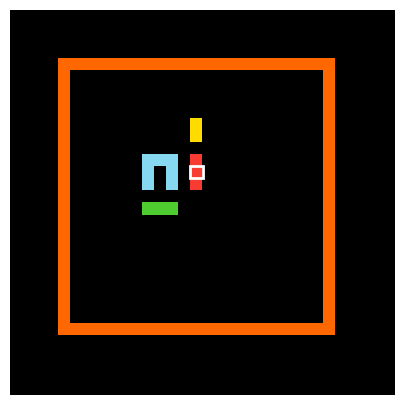

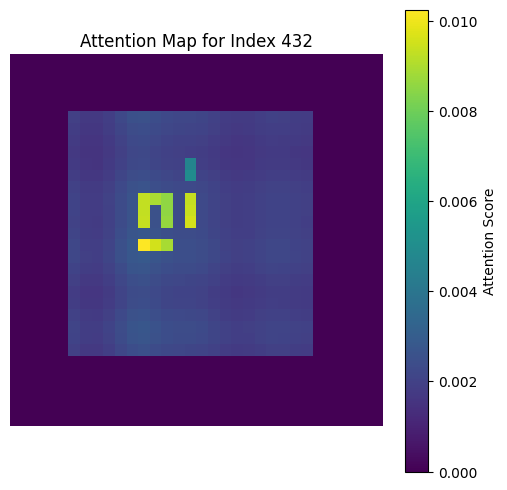

In [14]:
idx = encoder.get_idx(x=15, y=13, CLS=False, size=sample_u.shape)
encoder.plot_tensor_with_highlight(sample_u, idx)
encoder.plot_attention_map(sample_attn, idx, size=sample_u.shape)

# Cosine Sim on CLS Token

In [15]:
# This will take some time -- it is generating CLS token embeddings for all images in the dataset
ids_list = []
images_tensor = []
cls_tensor = []

with torch.no_grad():
    ViT.eval()
    for i, (ids, u, _, _, _, _) in enumerate(dataloader):
        B, H, W = u.shape
        u = u.to(device)

        cls_logits, _, _ = ViT(u, save_attn=False, temperature=1)

        ids_list.extend(ids)
        images_tensor.append(u.cpu())
        cls_tensor.append(cls_logits[:, 0].cpu())
        if i > 100:
            break
        
    images_tensor = torch.cat(images_tensor, dim=0)
    cls_tensor = torch.cat(cls_tensor, dim=0)

In [16]:
def get_delta_vec(t_embs, transformation):
    with torch.no_grad():
        vec = t_embs.get_embedding(transformation)
        return vec.cpu()

Reference Image


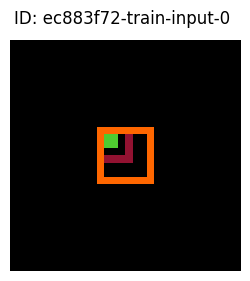

Transformation vectors applied: {'translation': 0, 'shuffle_colors': 0, 'rotate': 0, 'vertical_mirror': 1, 'horizontal_mirror': 0, 'resize': 0}




Closest 5 images:


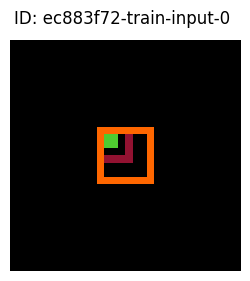

Similarity = 0.816



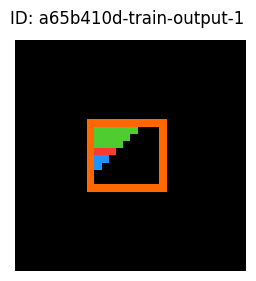

Similarity = 0.715



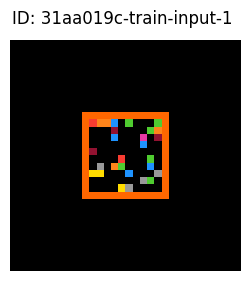

Similarity = 0.695



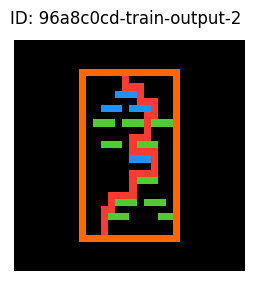

Similarity = 0.689



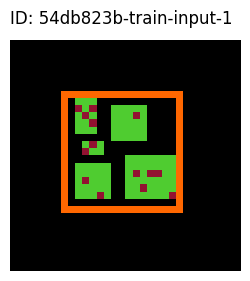

Similarity = 0.664




Furthest 5 images:


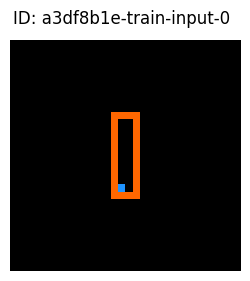

Similarity = -0.610



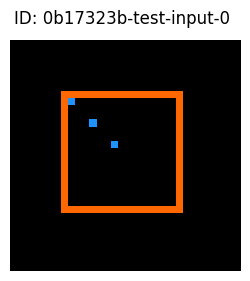

Similarity = -0.579



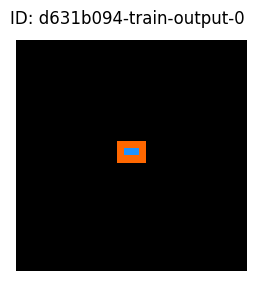

Similarity = -0.568



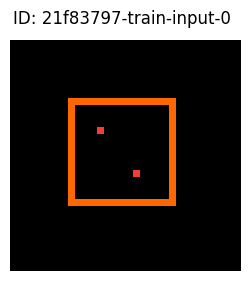

Similarity = -0.563



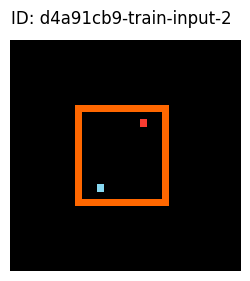

Similarity = -0.554



In [17]:
# Compute cosine similarity for given id
# id  = 'd4a91cb9-train-output-1'
# idx = ids_list.index(id)
idx = 2

transformation = {
    'translation': 0,
    'shuffle_colors': 0,
    'rotate': 0,
    'vertical_mirror': 1,
    'horizontal_mirror': 0,
    'resize': 0
}

vec = get_delta_vec(t_embs, transformation)


print(f"Reference Image")
encoder.plot_tensors_with_colors(images_tensor[idx:idx+1], f"ID: {ids_list[idx]}")
print(f"Transformation vectors applied: {transformation}")
print(f"{'='*60}\n")

# Compute our closest and furthest embeddings
k = 5
closest_embeddings, closest_sims = encoder.top_k_cosine_similarity(cls_tensor, idx, k, vec, largest=True)
furthest_embeddings, furthest_sims = encoder.top_k_cosine_similarity(cls_tensor, idx, k, vec, largest=False)


print(f"\n\n\nClosest {k} images:")
for i, closest_idx in enumerate(closest_embeddings):
    closest_id = ids_list[closest_idx]
    encoder.plot_tensors_with_colors(images_tensor[closest_idx:closest_idx+1], f"ID: {closest_id}")
    print(f"Similarity = {closest_sims[i]:.3f}\n")

print(f"\n\n\nFurthest {k} images:")
for i, furthest_idx in enumerate(furthest_embeddings):
    furthest_id = ids_list[furthest_idx]
    encoder.plot_tensors_with_colors(images_tensor[furthest_idx:furthest_idx+1], f"ID: {furthest_id}")
    print(f"Similarity = {furthest_sims[i]:.3f}\n")